# Spectrum Continuum Normalization

## Aim:
   - To perform Chi^2 comparision between PHOENIX ACES spectra and my CRIRES observations.
     
## Problem:
   - The nomalization of the observed spectra
   - Differences in the continuum normalization affect the chi^2 comparison when using mixed models of two different spectra. 
   
### Proposed Solution:
  - equation (1) from [Passegger 2016](https://arxiv.org/pdf/1601.01877.pdf) 
          Fobs = F obs * (cont_fit model / cont_fit observation) where con_fit is a linear fit to the spectra.
To take out and linear trends in the continuums and correct the amplitude of the continuum.
   
   
In this notebook I outline what I do currently showing an example.





In [1]:
import copy
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

% matplotlib inline
#%matplotlib auto


The obeservatios were originally automatically continuum normalized in the iraf extraction pipeline. 

I believe the continuum is not quite at 1 here anymore due to the divsion by the telluric spectra.

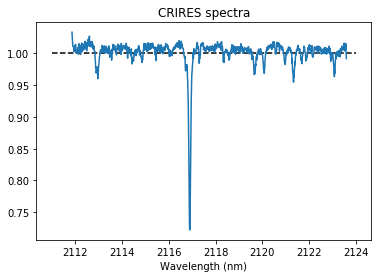

In [2]:
# Observation
obs = fits.getdata("/home/jneal/.handy_spectra/HD211847-1-mixavg-tellcorr_1.fits")

plt.plot(obs["wavelength"], obs["flux"])
plt.hlines(1, 2111, 2124, linestyle="--")
plt.title("CRIRES spectra")
plt.xlabel("Wavelength (nm)")
plt.show()

The two PHOENIX ACES spectra here are the first best guess of the two spectral components.

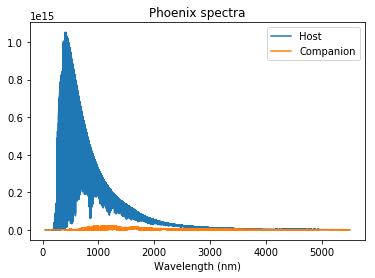

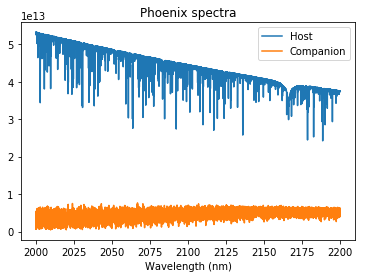

In [3]:
# Models
wav_model = fits.getdata("/home/jneal/Phd/data/PHOENIX-ALL/PHOENIX/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits")
wav_model /= 10   # nm
host = "/home/jneal/Phd/data/PHOENIX-ALL/PHOENIX/Z-0.0/lte05700-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits"
old_companion = "/home/jneal/Phd/data/PHOENIX-ALL/PHOENIX/Z-0.0/lte02600-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits"
companion = "/home/jneal/Phd/data/PHOENIX-ALL/PHOENIX/Z-0.0/lte02300-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits"

host_f = fits.getdata(host)
comp_f = fits.getdata(companion)
plt.plot(wav_model, host_f, label="Host")
plt.plot(wav_model, comp_f, label="Companion")
plt.title("Phoenix spectra")
plt.xlabel("Wavelength (nm)")
plt.legend()

plt.show()

mask = (2000 < wav_model) & (wav_model < 2200)
wav_model = wav_model[mask] 
host_f = host_f[mask] 
comp_f = comp_f[mask] 


plt.plot(wav_model, host_f, label="Host")
plt.plot(wav_model, comp_f, label="Companion")
plt.title("Phoenix spectra")
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.show()

# Current Normalization
I then continuum normalize the Phoenix spectrum locally around my observations 
by fitting an **exponenital** to the continuum like so.

- Split the spectrum into 50 bins
- Take median of 20 highest points in each bin.
- Fix an exponetial
- Evaulate at the orginal wavelength values
- Divide original by the fit


In [4]:
def get_continuum_points(wave, flux, splits=50, top=20):
    """Get continuum points along a spectrum.

    This splits a spectrum into "splits" number of bins and calculates
    the medain wavelength and flux of the upper "top" number of flux
    values.
    """
    # Shorten array until can be evenly split up.
    remainder = len(flux) % splits
    if remainder:
        # Nozero reainder needs this slicing
        wave = wave[:-remainder]
        flux = flux[:-remainder]

    wave_shaped = wave.reshape((splits, -1))
    flux_shaped = flux.reshape((splits, -1))

    s = np.argsort(flux_shaped, axis=-1)[:, -top:]

    s_flux = np.array([ar1[s1] for ar1, s1 in zip(flux_shaped, s)])
    s_wave = np.array([ar1[s1] for ar1, s1 in zip(wave_shaped, s)])

    wave_points = np.median(s_wave, axis=-1)
    flux_points = np.median(s_flux, axis=-1)
    assert len(flux_points) == splits

    return wave_points, flux_points


def continuum(wave, flux, splits=50, method='scalar', plot=False, top=20):
    """Fit continuum of flux.

    top: is number of top points to take median of continuum.
    """
    org_wave = wave[:]
    org_flux = flux[:]

    # Get continuum value in chunked sections of spectrum.
    wave_points, flux_points = get_continuum_points(wave, flux, splits=splits, top=top)

    poly_num = {"scalar": 0, "linear": 1, "quadratic": 2, "cubic": 3}

    if method == "exponential":
        z = np.polyfit(wave_points, np.log(flux_points), deg=1, w=np.sqrt(flux_points))
        p = np.poly1d(z)
        norm_flux = np.exp(p(org_wave))   # Un-log the y values.
    else:
        z = np.polyfit(wave_points, flux_points, poly_num[method])
        p = np.poly1d(z)
        norm_flux = p(org_wave)

    if plot:
        plt.subplot(211)
        plt.plot(wave, flux)
        plt.plot(wave_points, flux_points, "x-", label="points")
        plt.plot(org_wave, norm_flux, label='norm_flux')
        plt.legend()
        plt.subplot(212)
        plt.plot(org_wave, org_flux / norm_flux)
        plt.title("Normalization")
        plt.xlabel("Wavelength (nm)")
        plt.show()

    return norm_flux


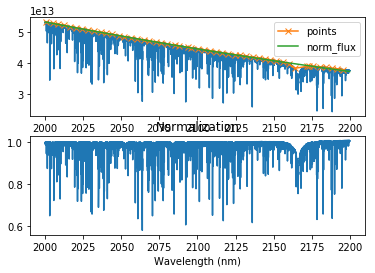

In [5]:
#host_cont = local_normalization(wav_model, host_f, splits=50, method="exponential", plot=True)
host_continuum = continuum(wav_model, host_f, splits=50, method="exponential", plot=True)

host_cont = host_f / host_continuum


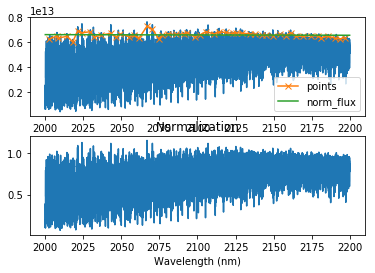

In [6]:
#comp_cont = local_normalization(wav_model, comp_f, splits=50, method="exponential", plot=True)

comp_continuum = continuum(wav_model, comp_f, splits=50, method="exponential", plot=True)

comp_cont = comp_f / comp_continuum

Above the top is the unnormalize spectra, with the median points in orangeand the green line the continuum fit. The bottom plot is the contiuum normalized result

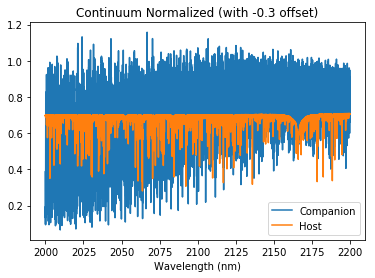

In [7]:
plt.plot(wav_model, comp_cont, label="Companion")
plt.plot(wav_model, host_cont-0.3, label="Host")
plt.title("Continuum Normalized (with -0.3 offset)")
plt.xlabel("Wavelength (nm)")
plt.legend()
plt.show()



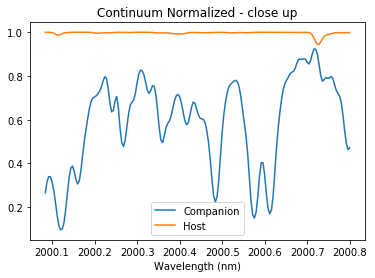

In [8]:
plt.plot(wav_model[20:200], comp_cont[20:200], label="Companion")
plt.plot(wav_model[20:200], host_cont[20:200], label="Host")
plt.title("Continuum Normalized - close up")
plt.xlabel("Wavelength (nm)")
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.legend()
plt.show()

# Combining Spectra
I then mix the models using a combination of the two spectra.
In this case with NO RV shifts.

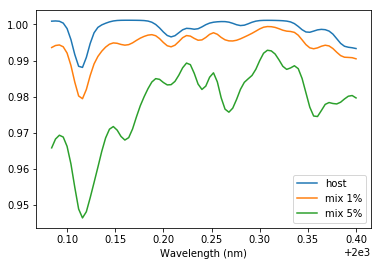

In [9]:
def mix(h, c, alpha):
    return (h + c * alpha) / (1 + alpha)

mix1 = mix(host_cont, comp_cont, 0.01)   # 1% of the companion spectra  
mix2 = mix(host_cont, comp_cont, 0.05)   # 5% of the companion spectra  

# plt.plot(wav_model[20:100], comp_cont[20:100], label="comp")
plt.plot(wav_model[20:100], host_cont[20:100], label="host")
plt.plot(wav_model[20:100], mix1[20:100], label="mix 1%")
plt.plot(wav_model[20:100], mix2[20:100], label="mix 5%")
plt.xlabel("Wavelength (nm)")
plt.legend()
plt.show()

The companion is cooler there are many more deeper lines present in the spectra.
Even a small contribution of the companion spectra reduce the continuum of the mixed spectra considerably.

When I compare these mixed spectra to my observations

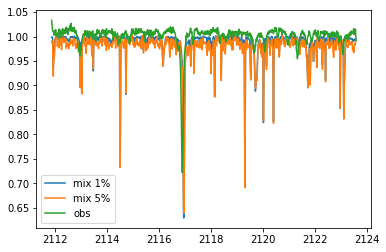

In [10]:
mask = (wav_model > np.min(obs["wavelength"])) & (wav_model < np.max(obs["wavelength"]))

plt.plot(wav_model[mask], mix1[mask], label="mix 1%")
plt.plot(wav_model[mask], mix2[mask], label="mix 5%")
plt.plot(obs["wavelength"], obs["flux"], label="obs")
#plt.xlabel("Wavelength (nm)")
plt.legend()
plt.show()



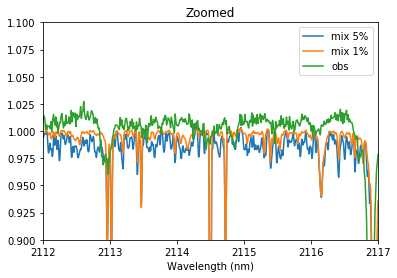

In [11]:
# Zoomed in
plt.plot(wav_model[mask], mix2[mask], label="mix 5%")
plt.plot(wav_model[mask], mix1[mask], label="mix 1%")
plt.plot(obs["wavelength"], obs["flux"], label="obs")
plt.xlabel("Wavelength (nm)")
plt.legend()
plt.xlim([2112, 2117])
plt.ylim([0.9, 1.1])
plt.title("Zoomed")
plt.show()

As you can see here my observations are above the continuum most of the time.
What I have noticed is this drastically affects the chisquared result as the mix model is the one with the least amount of alpha.

I am thinking of renormalizing my observations by implementing equation (1) from [Passegger 2016](https://arxiv.org/pdf/1601.01877.pdf) *(Fundamental M-dwarf parameters from high-resolution spectra using PHOENIX ACES modesl)*

            F_obs = F_obs * (continuum_fit model / continuum_fit observation)
            
They fit a linear function to the continuum of the observation and computed spectra to account for *"slight differences in the continuum level and possible linear trends between the already noramlized spectra."* 

- One difference is that they say they normalize the **average** flux of the spectra to unity. Would this make a difference in this method.


## Questions
- Would this be the correct approach to take to solve this? 
- Should I renomalize the observations first as well?
- Am I treating the cooler M-dwarf spectra correctly in this approach? 


### Attempting the Passegger method

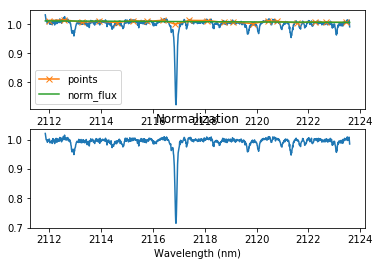

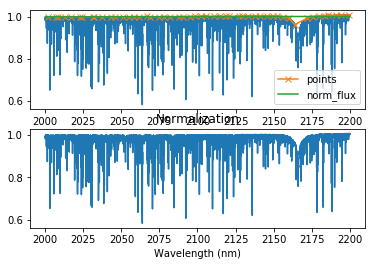

In [12]:

from scipy.interpolate import interp1d
# mix1_norm = continuum(wav_model, mix1, splits=50, method="linear", plot=False)
# mix2_norm = local_normalization(wav_model, mix2, splits=50, method="linear", plot=False)
obs_continuum = continuum(obs["wavelength"], obs["flux"], splits=20, method="linear", plot=True)

linear1 = continuum(wav_model, mix1, splits=50, method="linear", plot=True)
linear2 = continuum(wav_model, mix2, splits=50, method="linear", plot=False)

obs_renorm1 = obs["flux"]  * (interp1d(wav_model, linear1)(obs["wavelength"]) / obs_continuum)
obs_renorm2 = obs["flux"]  * (interp1d(wav_model, linear2)(obs["wavelength"]) / obs_continuum)



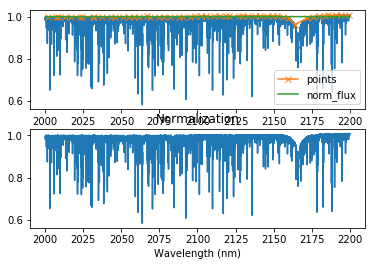

[ 0.9982427  0.9982427  0.9982427 ...,  0.9982427  0.9982427  0.9982427]


In [13]:
# Just a scalar
# mix1_norm = local_normalization(wav_model, mix1, splits=50, method="scalar", plot=False)
# mix2_norm = local_normalization(wav_model, mix2, splits=50, method="scalar", plot=False)
obs_scalar = continuum(obs["wavelength"], obs["flux"], splits=20, method="scalar", plot=False)
scalar1 = continuum(wav_model, mix1, splits=50, method="scalar", plot=True)
scalar2 = continuum(wav_model, mix2, splits=50, method="scalar", plot=False)
print(scalar2)
obs_renorm_scalar1 = obs["flux"] * (interp1d(wav_model, scalar1)(obs["wavelength"]) / obs_scalar)
obs_renorm_scalar2 = obs["flux"] * (interp1d(wav_model, scalar2)(obs["wavelength"]) / obs_scalar)

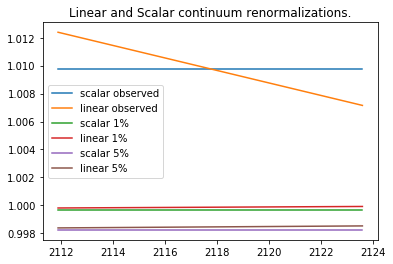

In [14]:
plt.plot(obs["wavelength"], obs_scalar, label="scalar observed")
plt.plot(obs["wavelength"], obs_continuum, label="linear observed")

plt.plot(obs["wavelength"], interp1d(wav_model, scalar1)(obs["wavelength"]), label="scalar 1%")
plt.plot(obs["wavelength"], interp1d(wav_model, linear1)(obs["wavelength"]), label="linear 1%")

plt.plot(obs["wavelength"], interp1d(wav_model, scalar2)(obs["wavelength"]), label="scalar 5%")
plt.plot(obs["wavelength"], interp1d(wav_model, linear2)(obs["wavelength"]), label="linear 5%")

plt.title("Linear and Scalar continuum renormalizations.")
plt.legend()
plt.show()

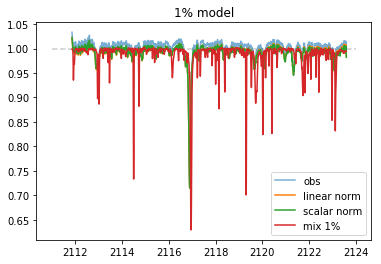

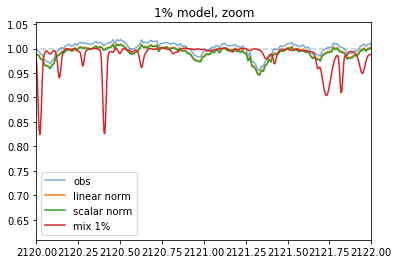

In [18]:
plt.plot(obs["wavelength"], obs["flux"],  label="obs", alpha =0.6)
plt.plot(obs["wavelength"], obs_renorm1, label="linear norm")
plt.plot(obs["wavelength"], obs_renorm_scalar1, label="scalar norm")
plt.plot(wav_model[mask], mix1[mask], label="mix 1%")
plt.legend()
plt.title("1% model")
plt.hlines(1, 2111, 2124, linestyle="--", alpha=0.2)
plt.show()

plt.plot(obs["wavelength"], obs["flux"],  label="obs", alpha =0.6)
plt.plot(obs["wavelength"], obs_renorm1, label="linear norm")
plt.plot(obs["wavelength"], obs_renorm_scalar1, label="scalar norm")
plt.plot(wav_model[mask], mix1[mask], label="mix 1%")
plt.legend()
plt.title("1% model, zoom")
plt.xlim([2120, 2122])
plt.hlines(1, 2111, 2124, linestyle="--", alpha=0.2)
plt.show()

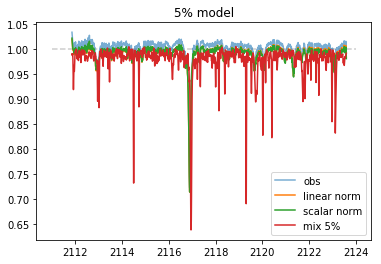

In [16]:
plt.plot(obs["wavelength"], obs["flux"],  label="obs", alpha =0.6)
plt.plot(obs["wavelength"], obs_renorm2, label="linear norm")
plt.plot(obs["wavelength"], obs_renorm_scalar2, label="scalar norm")
plt.plot(wav_model[mask], mix2[mask], label="mix 5%")
plt.legend()
plt.title("5% model")
plt.hlines(1, 2111, 2124, linestyle="--", alpha=0.2)
plt.show()


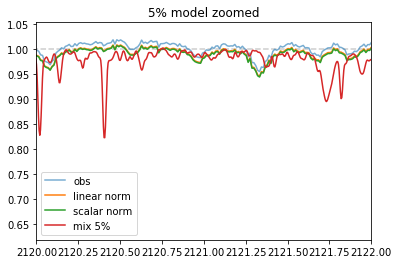

In [17]:

plt.plot(obs["wavelength"], obs["flux"],  label="obs", alpha =0.6)
plt.plot(obs["wavelength"], obs_renorm2, label="linear norm")
plt.plot(obs["wavelength"], obs_renorm_scalar2, label="scalar norm")
plt.plot(wav_model[mask], mix2[mask], label="mix 5%")
plt.legend()
plt.title("5% model zoomed")
plt.xlim([2120, 2122])
plt.hlines(1, 2111, 2124, linestyle="--", alpha=0.2)
plt.show()

In this example for the 5% companion spectra there is a bit of difference between the linear and scalar normalizations. With a larger difference at the longer wavelength. (more orange visible above the red.)  Faint blue is the spectrum before the renormalization.

# Range of phoenix spectra



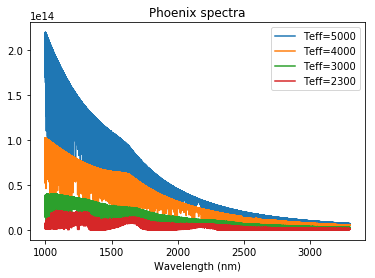

In [19]:
wav_model = fits.getdata("/home/jneal/Phd/data/PHOENIX-ALL/PHOENIX/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits")
wav_model /= 10   # nm
temps = [2300, 3000, 4000, 5000]

mask1 = (1000 < wav_model) & (wav_model < 3300)
masked_wav1 = wav_model[mask1] 
for temp in temps[::-1]:
    file = "/home/jneal/Phd/data/PHOENIX-ALL/PHOENIX/Z-0.0/lte0{0}-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits".format(temp)
    host_f = fits.getdata(file)
    
    plt.plot(masked_wav1, host_f[mask1], label="Teff={}".format(temp))
    
plt.title("Phoenix spectra")
plt.xlabel("Wavelength (nm)")
plt.legend()

plt.show()



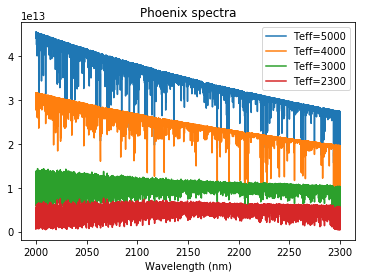

In [20]:

mask = (2000 < wav_model) & (wav_model < 2300)
masked_wav = wav_model[mask] 

for temp in temps[::-1]:
    file = "/home/jneal/Phd/data/PHOENIX-ALL/PHOENIX/Z-0.0/lte0{0}-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits".format(temp)
    host_f = fits.getdata(file)

    host_f = host_f[mask] 

    plt.plot(masked_wav, host_f, label="Teff={}".format(temp))
    
plt.title("Phoenix spectra")
plt.xlabel("Wavelength (nm)")
plt.legend()

plt.show()


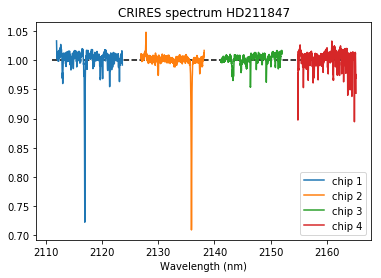

In [21]:
# Observations
for chip in range(1,5):
    obs = fits.getdata("/home/jneal/.handy_spectra/HD211847-1-mixavg-tellcorr_{}.fits".format(chip))

    plt.plot(obs["wavelength"], obs["flux"], label="chip {}".format(chip))
plt.hlines(1, 2111, 2165, linestyle="--")
plt.title("CRIRES spectrum HD211847")
plt.xlabel("Wavelength (nm)")
plt.legend()
plt.show()

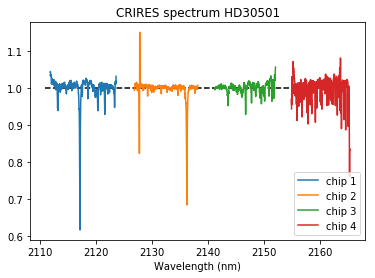

In [22]:
# Observations
for chip in range(1,5):
    obs = fits.getdata("/home/jneal/.handy_spectra/HD30501-1-mixavg-tellcorr_{}.fits".format(chip))

    plt.plot(obs["wavelength"], obs["flux"], label="chip {}".format(chip))
plt.hlines(1, 2111, 2165, linestyle="--")
plt.title("CRIRES spectrum HD30501")
plt.xlabel("Wavelength (nm)")
plt.legend()
plt.show()